Base directory will contain all the 5 BBBD datasets, and will be created in this current directory unless changed to a different location

In [1]:
base_dir = r'.\bbbd_datasets' # '/path/to/downloads/directory'

Function to download and unzip each experiment's dataset

In [2]:
import requests
import zipfile
import os

def bbbd_download_unzip(expno, output_dir, output_file=None):
    url = f'https://fcp-indi.s3.amazonaws.com/data/Projects/CUNY_MADSEN/BBBD/bids_data/experiment{expno}.zip'
    if output_file is None:
        output_file = os.path.join(output_dir, url.split("/")[-1])
    os.makedirs(output_dir, exist_ok=True)
    
    # Download 
    print(f"Downloading from {url}...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(output_file, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        print(f"Download completed: {output_file}")
    else:
        print(f"Failed to download. Status code: {response.status_code}")
        return None
    
    # Unzip
    if zipfile.is_zipfile(output_file):
        print(f"Unzipping {output_file}...")
        with zipfile.ZipFile(output_file, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
        print(f"Extracted to: {output_dir}")
        os.remove(output_file)
    else:
        print(f"{output_file} is not a ZIP file, skipping extraction.")
    return output_file

Download all 5 datasets to the base_dir by running the cell below

In [ ]:
expnos = [1,2,3,4,5]
for expno in expnos:
    bbbd_download_unzip(expno, base_dir)

Run this command in your terminal to install the packages if you do not have them 

pip install pandas numpy seaborn matplotlib scipy mne

Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

1) Physiological Signals

In [6]:
def load_and_plot_physio(signal_file, rate_file, peak_file, fs_signal, fs_rate, start_time, end_time, signal_label, rate_label):
    signal_df = pd.read_csv(signal_file, sep='\t', compression='gzip', header=None)
    rate_df = pd.read_csv(rate_file, sep='\t', compression='gzip')
    peak_df = pd.read_csv(peak_file, sep='\t', compression='gzip')

    signal = signal_df.values  
    rate = rate_df[1:].values
    peaks_time = peak_df[1:].values

    time_signal = np.arange(len(signal)) / fs_signal
    time_rate = np.arange(len(rate)) / fs_rate

    signal_mask = (time_signal >= start_time) & (time_signal <= end_time)
    rate_mask = (time_rate >= start_time) & (time_rate <= end_time)

    signal_segment = signal[signal_mask]
    rate_segment = rate[rate_mask]
    time_signal_segment = time_signal[signal_mask]
    time_rate_segment = time_rate[rate_mask]

    peak_indices = np.floor(peaks_time * fs_signal).astype(int)
    peak_indices = peak_indices[(peak_indices >= 0) & (peak_indices < len(signal))] 
    peak_values = signal[peak_indices]
    peak_values_rate = rate[peak_indices]

    plt.rcParams.update({'font.size': 15})
    fig, axes = plt.subplots(2, 1, figsize=(15, 5), sharex=True) 

    signal_color = 'blue'
    rate_color = 'green'
    peak_color = 'red'

    # Signal
    axes[0].plot(time_signal_segment, signal_segment, label=f"{signal_label} Signal", color=signal_color)
    axes[0].scatter(time_signal[peak_indices], peak_values, color=peak_color, label='Peaks', zorder=5)
    axes[0].set_ylabel('Amplitude (mV)') 
    axes[0].grid(True)

    # Rate
    axes[1].plot(time_rate_segment, rate_segment, label=f"{rate_label} Rate", color=rate_color)
    axes[1].scatter(time_rate[peak_indices], peak_values_rate, color=peak_color, zorder=5)
    axes[1].set_xlabel('Time (s)')
    if rate_label == 'Breath':
        axes[1].set_ylabel(f'{rate_label}s / Minute')
    else:
        axes[1].set_ylabel(f'Beats / Minute')
    axes[1].grid(True)

    axes[0].set_xlim(start_time, end_time)

    lines_labels = [ax.get_legend_handles_labels() for ax in axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]  

    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3, frameon=False)
    plt.tight_layout(rect=[0, 0, 1, 0.89])  
    plt.show()



Figure 8: Respiration

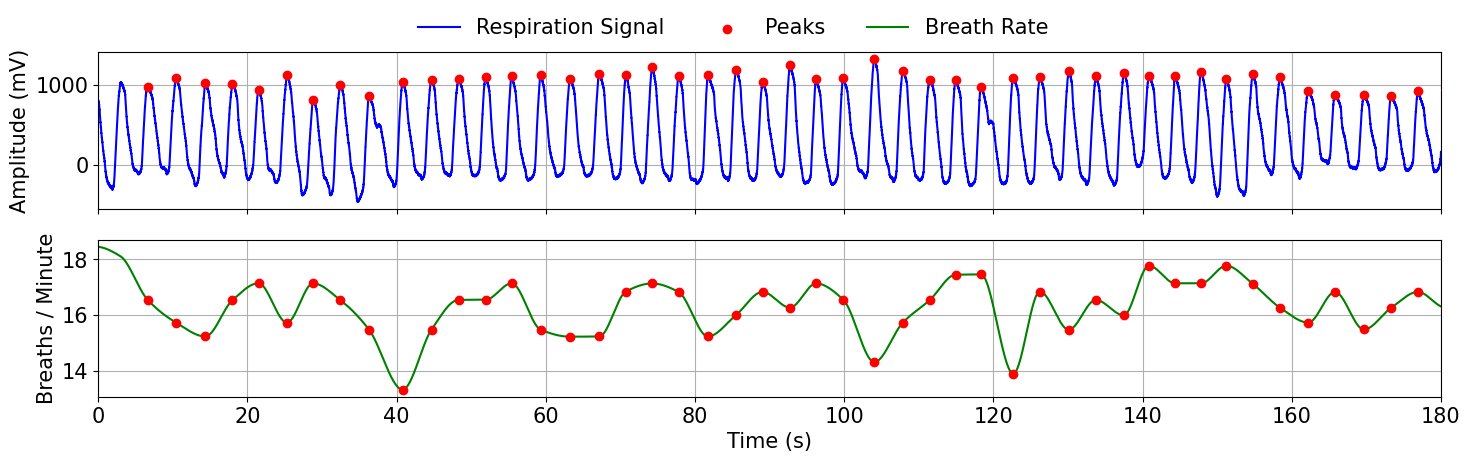

In [7]:
expno = 4  # Experiment number
subno = 12  # Subject number
sesno = 1  # Session number
stimno = 6  # Stimulus number

signal_file_path = f'{base_dir}\\experiment{expno}\\sub-{subno}\\ses-0{sesno}\\beh\\sub-{subno}_ses-0{sesno}_task-stim0{stimno}_recording-respiration_physio.tsv.gz'
rate_file_path = f'{base_dir}\\experiment{expno}\\derivatives\\sub-{subno}\\ses-0{sesno}\\beh\\sub-{subno}_ses-0{sesno}_task-stim0{stimno}_desc-breathrate.tsv.gz'
peak_file_path = f'{base_dir}\\experiment{expno}\\derivatives\\sub-{subno}\\ses-0{sesno}\\beh\\sub-{subno}_ses-0{sesno}_task-stim0{stimno}_desc-breath_peak_timestamps.tsv.gz'

load_and_plot_physio(signal_file_path, rate_file_path, peak_file_path, fs_signal = 128, fs_rate = 128, start_time = 0, end_time = 180, signal_label = "Respiration", rate_label = "Breath")

Figure 6: ECG

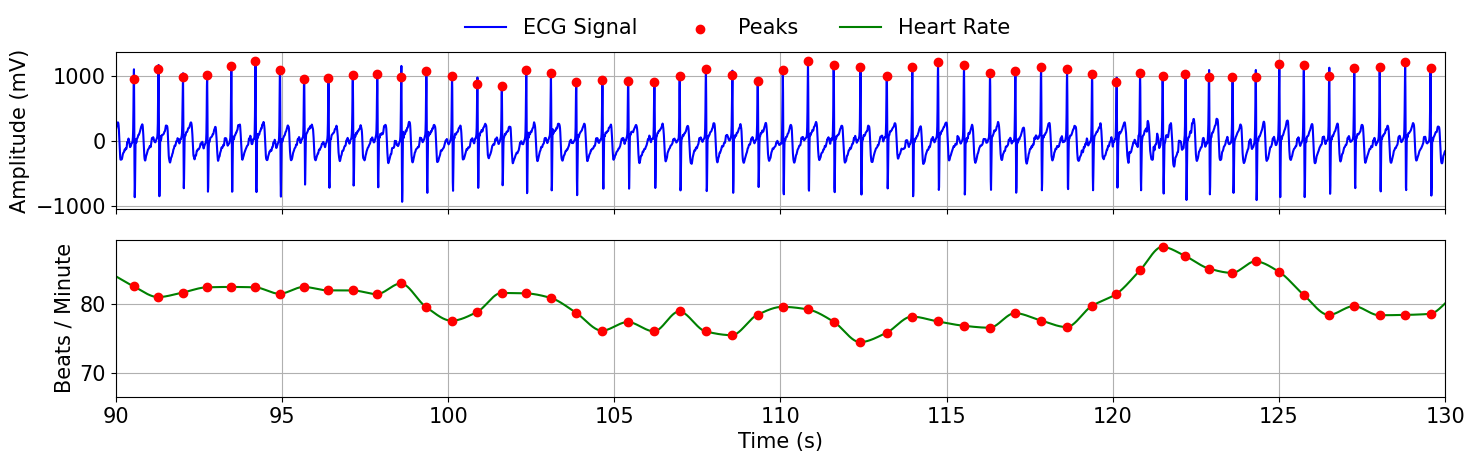

In [8]:
expno = 5  # Experiment number
subno = 11  # Subject number
sesno = 1  # Session number
stimno = 1  # Stimulus number

signal_file_path = f'{base_dir}\\experiment{expno}\\derivatives\\sub-{subno}\\ses-0{sesno}\\beh\\sub-{subno}_ses-0{sesno}_task-stim0{stimno}_desc-filteredECG.tsv.gz'
rate_file_path = f'{base_dir}\\experiment{expno}\\derivatives\\sub-{subno}\\ses-0{sesno}\\beh\\sub-{subno}_ses-0{sesno}_task-stim0{stimno}_desc-heartrate.tsv.gz'
peak_file_path = f'{base_dir}\\experiment{expno}\\derivatives\\sub-{subno}\\ses-0{sesno}\\beh\\sub-{subno}_ses-0{sesno}_task-stim0{stimno}_desc-rpeak_timestamps.tsv.gz'


load_and_plot_physio(signal_file_path, rate_file_path, peak_file_path, fs_signal = 128, fs_rate = 128, start_time = 90, end_time = 130, signal_label = "ECG", rate_label = "Heart")

Figure 5: EOG

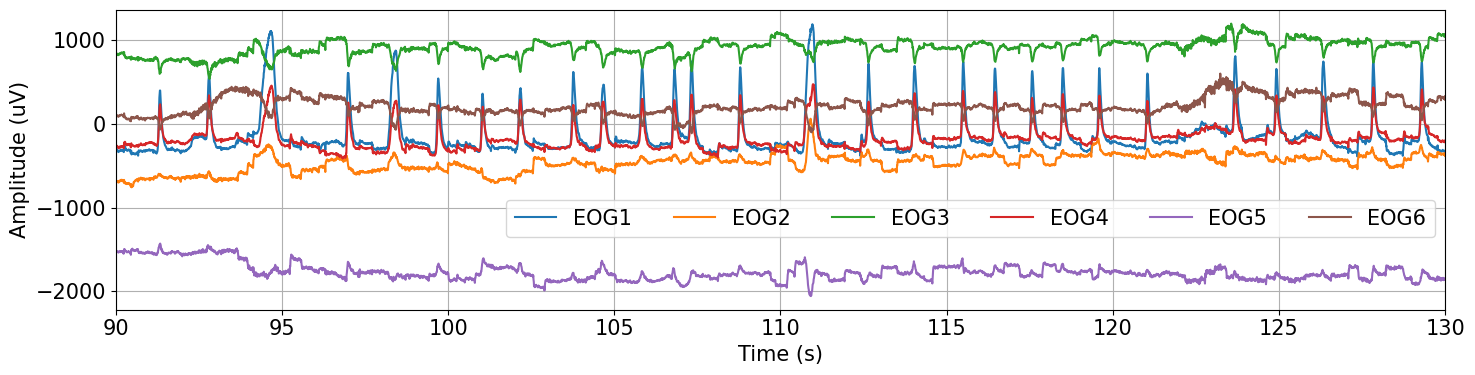

In [9]:
exp_no = 4
sub = 20 
ses = 1
stim = 4

file_name = rf'{base_dir}\experiment{exp_no}\sub-{sub}\ses-0{ses}\beh\sub-{sub}_ses-0{ses}_task-stim0{stim}_recording-eog_physio.tsv.gz'
data = pd.read_csv(file_name, sep='\t', compression='gzip', header=None)
n_samples_ecg = len(data.values)
time_array = np.arange(n_samples_ecg) / 128

start_time = 90
end_time = 130

segment_mask = (time_array >= start_time) & (time_array <= end_time)
segment = data.values[segment_mask]
time_segment = time_array[segment_mask]

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(15, 4))

for i in range(data.shape[1]): 
    plt.plot(time_segment, segment[:, i], label=f'EOG{i+1}')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')  
plt.xlim(start_time, end_time)
plt.grid(True)
plt.legend(ncol=6, bbox_to_anchor=(1, 0.4))
plt.tight_layout()
plt.show()

2. Eyetracking Signals

Figure 7: Eyetracking signals overview

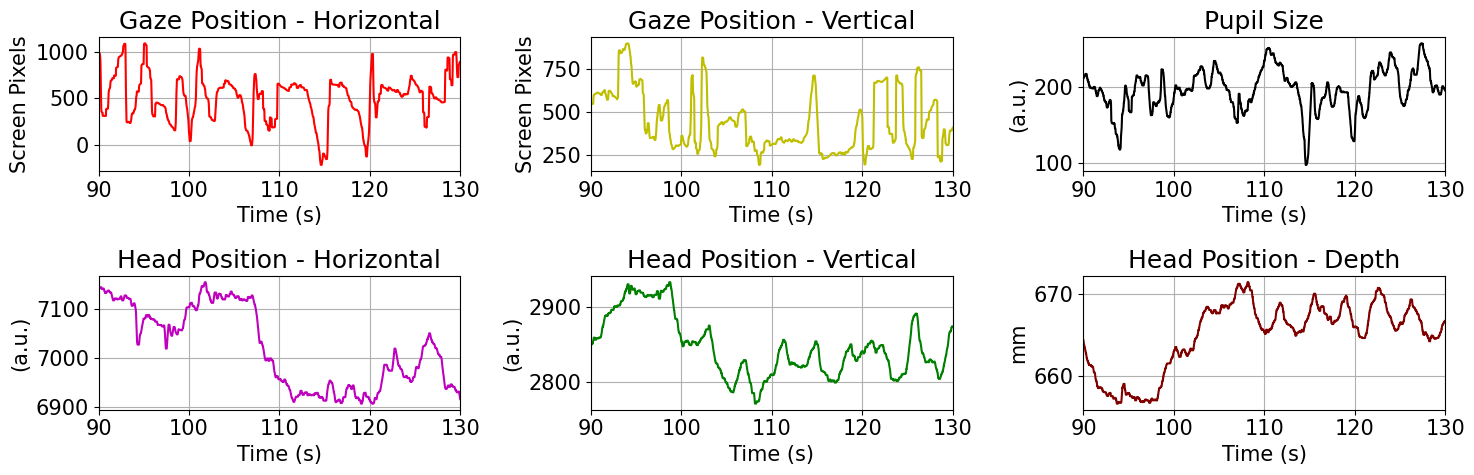

In [10]:
expno = 3  # Experiment number
subno = 11  # Subject number
sesno = 1  # Session number
stimno = 1  # Stimulus number

gaze_path = f'{base_dir}\\experiment{expno}\\derivatives\\sub-{subno}\\ses-0{sesno}\\eyetrack\\sub-{subno}_ses-0{sesno}_task-stim0{stimno}_desc-gaze_eyetrack.tsv.gz'
pupil_path = f'{base_dir}\\experiment{expno}\\derivatives\\sub-{subno}\\ses-0{sesno}\\eyetrack\\sub-{subno}_ses-0{sesno}_task-stim0{stimno}_desc-pupil_eyetrack.tsv.gz'
head_path = f'{base_dir}\\experiment{expno}\\derivatives\\sub-{subno}\\ses-0{sesno}\\eyetrack\\sub-{subno}_ses-0{sesno}_task-stim0{stimno}_desc-head_eyetrack.tsv.gz'
json_file_path = f'{base_dir}\\experiment{expno}\\sub-{subno}\\ses-0{sesno}\\eyetrack\\sub-{subno}_ses-0{sesno}_task-stim0{stimno}_gaze_eyetrack.json'


with open(json_file_path, 'r') as json_file:
    metadata = json.load(json_file)

fs = metadata['SamplingFrequency']  # Hz

gaze_data = pd.read_csv(gaze_path, sep='\t', compression='gzip', header=None)
pupil_data = pd.read_csv(pupil_path, sep='\t', compression='gzip', header=None)
head_data = pd.read_csv(head_path, sep='\t', compression='gzip', header=None)

gaze_x = gaze_data[0].values  
gaze_y = gaze_data[1].values

pupilsize = pupil_data.values

head_signal_x = head_data[0].values  
head_signal_y = head_data[1].values
head_signal_z = head_data[2].values

# Time arrays
n_samples_eye = len(gaze_x)
time_eyetracker = np.arange(n_samples_eye) / fs

# time segment duration in sec
start_time = 90  
end_time = 130  
segment_mask = (time_eyetracker >= start_time) & (time_eyetracker <= end_time)
time_segment = time_eyetracker[segment_mask]

# Extract the segment for Eye
gaze_segment_x = gaze_x[segment_mask]
gaze_segment_y = gaze_y[segment_mask]
pupilsize_segment = pupilsize[segment_mask]

# Extract the segment for Head
head_segment_x = head_signal_x[segment_mask]
head_segment_y = head_signal_y[segment_mask]
head_segment_z = head_signal_z[segment_mask]

plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(2, 3, figsize=(15,5))

# Plot Eye segment - X Axis
axs[0, 0].plot(time_segment, gaze_segment_x, color='r', label='gaze_x')
axs[0, 0].set_title(f'Gaze Position - Horizontal')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_xlim(start_time,end_time)
axs[0, 0].set_ylabel('Screen Pixels') 
axs[0, 0].grid(True)
# axs[0, 0].legend()

# Plot Eye segment - Y Axis
axs[0, 1].plot(time_segment, gaze_segment_y, color='y', label='gaze_y')
axs[0, 1].set_title(f'Gaze Position - Vertical')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Screen Pixels')  
axs[0, 1].set_xlim(start_time,end_time)
axs[0, 1].grid(True)
# axs[0, 1].legend()

# Plot Eye segment - Pupil Size
axs[0, 2].plot(time_segment, pupilsize_segment, color='black', label='pupil area')
axs[0, 2].set_title(f'Pupil Size')
axs[0, 2].set_xlabel('Time (s)')
axs[0, 2].set_ylabel('(a.u.)')  
axs[0, 2].set_xlim(start_time,end_time)
axs[0, 2].grid(True)
# axs[0, 2].legend()

# Plot Head segment - X Axis
axs[1, 0].plot(time_segment, head_segment_x, color='m', label='head_x')
axs[1, 0].set_title(f'Head Position - Horizontal')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('(a.u.)')  
axs[1, 0].set_xlim(start_time,end_time)
axs[1, 0].grid(True)
# axs[1, 0].legend()

# Plot Head segment - Y Axis
axs[1, 1].plot(time_segment, head_segment_y, color='g', label='head_y')
axs[1, 1].set_title(f'Head Position - Vertical')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('(a.u.)')  
axs[1, 1].set_xlim(start_time,end_time)
axs[1, 1].grid(True)
# axs[1, 1].legend()

# Plot Head segment - Z Axis
axs[1, 2].plot(time_segment, head_segment_z, color='maroon', label='head_z')
axs[1, 2].set_title(f'Head Position - Depth')
axs[1, 2].set_xlabel('Time (s)')
axs[1, 2].set_ylabel('mm')  
axs[1, 2].set_xlim(start_time,end_time)
axs[1, 2].grid(True)
# axs[1, 2].legend()

# Adjust layout
plt.tight_layout()
plt.show()


Figure: Gaze, saccades, blinks, fixations overlay

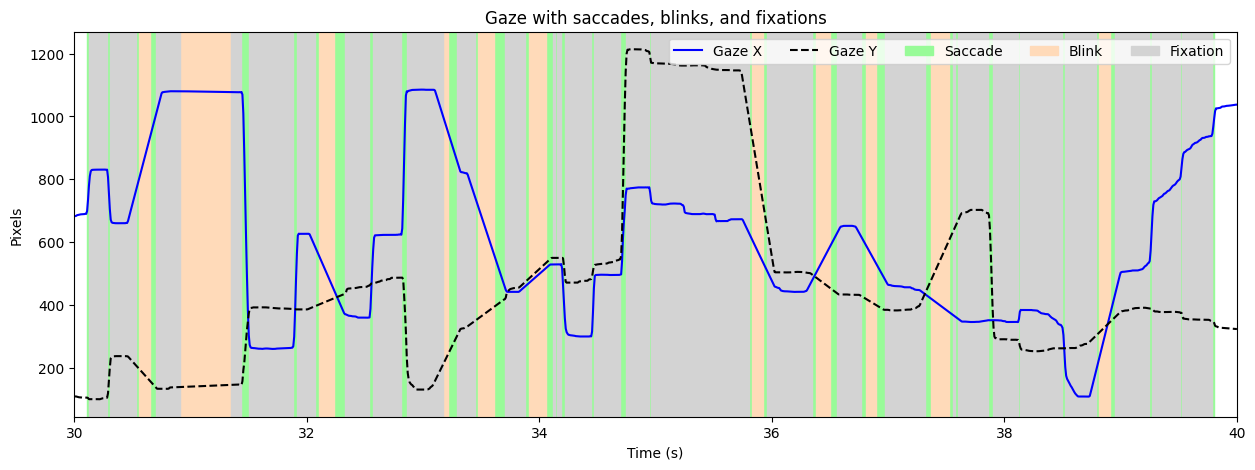

In [ ]:
expno = 5
subno = '01' 
stimno = 3
sesno = 2

blinks_path = f'{base_dir}\\experiment{expno}\\derivatives\\sub-{subno}\\ses-0{sesno}\\eyetrack\\sub-{subno}_ses-0{sesno}_task-stim0{stimno}_desc-blinks.tsv.gz'
blinks = pd.read_csv(blinks_path, sep='\t', compression='gzip')

saccades_path = f'{base_dir}\\experiment{expno}\\derivatives\\sub-{subno}\\ses-0{sesno}\\eyetrack\\sub-{subno}_ses-0{sesno}_task-stim0{stimno}_desc-saccades.tsv.gz'
saccades = pd.read_csv(saccades_path, sep='\t', compression='gzip')

fixations_path = f'{base_dir}\\experiment{expno}\\derivatives\\sub-{subno}\\ses-0{sesno}\\eyetrack\\sub-{subno}_ses-0{sesno}_task-stim0{stimno}_desc-fixations.tsv.gz'
fixations = pd.read_csv(fixations_path, sep='\t', compression='gzip')

eye_path = f'{base_dir}\\experiment{expno}\\derivatives\\sub-{subno}\\ses-0{sesno}\\eyetrack\\sub-{subno}_ses-0{sesno}_task-stim0{stimno}_desc-gaze_eyetrack.tsv.gz'
eye = pd.read_csv(eye_path, sep='\t', compression='gzip', header=None)

fs_eye = 128

gaze = eye.iloc[:, [0, 1]]
gazex = np.array(gaze.iloc[:, 0])
gazey = np.array(gaze.iloc[:, 1])

# Calculate time vector for eye data
n_samples_eye = len(gazex)
time_eye = np.arange(n_samples_eye) / fs_eye

seg_start = 30
seg_end = 40

# Define segment range and mask
eye_segment_mask = (time_eye >= seg_start) & (time_eye <= seg_end)
time_eye_segment = time_eye[eye_segment_mask]
gazex_segment = gazex[eye_segment_mask]  
gazey_segment = gazey[eye_segment_mask]  

# Plot gazex data for the segment
plt.figure(figsize=(15, 5))
plt.plot(time_eye_segment, gazex_segment, label="Gaze X", color='blue')  
plt.plot(time_eye_segment, gazey_segment, label="Gaze Y", color='black', linestyle='--')  

# Flag variables to add legend labels only once per interval type
saccade_added, blink_added, fixation_added = False, False, False

# Overlay saccade intervals within the time segment
for _, row in saccades.iterrows():
    start_time = row['start_time']
    end_time = row['end_time']
    if start_time >= time_eye_segment[0] and end_time <= time_eye_segment[-1]:  # Plot within segment range
        if not saccade_added:
            plt.axvspan(start_time, end_time, color='palegreen', label="Saccade")
            saccade_added = True
        else:
            plt.axvspan(start_time, end_time, color='palegreen')

# Overlay blink intervals within the time segment
for _, row in blinks.iterrows():
    start_time = row['start_time']
    end_time = row['end_time']
    if start_time >= time_eye_segment[0] and end_time <= time_eye_segment[-1]:  # Plot within segment range
        if not blink_added:
            plt.axvspan(start_time, end_time, color='peachpuff', label="Blink")
            blink_added = True
        else:
            plt.axvspan(start_time, end_time, color='peachpuff')
            
# Overlay fixation intervals within the time segment
for _, row in fixations.iterrows():
    start_time = row['start_time']
    end_time = row['end_time']
    if start_time >= time_eye_segment[0] and end_time <= time_eye_segment[-1]:  # Plot within segment range
        if not fixation_added:
            plt.axvspan(start_time, end_time, color='lightgrey', label="Fixation")  
            fixation_added = True
        else:
            plt.axvspan(start_time, end_time, color='lightgrey')

plt.xlabel("Time (s)")
plt.ylabel("Pixels")
plt.xlim(seg_start, seg_end)
plt.title("Gaze with saccades, blinks, and fixations")
plt.legend(ncol=5)  
plt.show()
